<a href="https://colab.research.google.com/github/maryyuliana/INTRODUCCION_AED_MAESTRIA/blob/main/20230911_EDA_TrabajoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Final Análisis Exploratorio de Datos

Elaborado por:
- *Mary Yuliana Jaramillo* - maryyuliana@gmail.com
- *Juan Fernando Gómez C* - juan.gomezcastaneda@u.icesi.edu.co

Se importan librerías necesarias.

In [ ]:
!pip install mapclassify
import pandas as pd
import geopandas as gpd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import folium
from folium.plugins import HeatMap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 689.2 kB/s eta 0:00:00


Preparación de los datos
### Lectura del archivo

In [ ]:
ofertas = pd.read_excel("https://github.com/HanisDad95/TalleresMSc/raw/main/Shapes/BASE_OFERT_GITHUB.xlsx")

### 1. Procesamiento de los datos
1.1 Eliminación de filas y columnas no objeto de estudio

Para este análisis sólo se usarán ofertas inmobiliarias en venta.

In [ ]:
ofertas = ofertas[ofertas['TIPO_OFERT']=='Venta']

In [ ]:
ofertas.columns

Index(['OBJECTID', 'BARRIO', 'COMUNA', 'TIPO_OFERT', 'TIPO_INMUE',
       'NOM_PROYEC', 'ESTRATO', 'VALOR_PEDI', 'VALOR_DEPU', 'FACTOR_DEP',
       'AREA_PRIVA', 'AREA_CONST', 'AREA_TERRE', 'PARQUEADER', 'DEPOSITOS',
       'PISOS', 'EDAD_COSNT', 'FECHA_OFER', 'FECHA_PUBL', 'CONDICION',
       'ASCENSOR', 'PISO', 'METODO_CON', 'LAT', 'LONG', 'COM_ESP', 'RADICADO'],
      dtype='object')

Se eliminan las variables que no se van a utilizar

In [ ]:
columnas_eliminar = [ 'BARRIO', 'NOM_PROYEC','TIPO_OFERT','VALOR_DEPU', 'FACTOR_DEP','PARQUEADER',
                      'DEPOSITOS','AREA_PRIVA','FECHA_PUBL', 'ASCENSOR', 'PISO', 'METODO_CON', 'COM_ESP']

In [ ]:
ofertas.drop(labels = columnas_eliminar, axis = 1, inplace = True)

Después de eliminar las columnas no necesarias para el análisis y filtrar sólo las ofertas en ventas, queda un total de 2119 ofertas y 14 variables

Descripción de las variables de interés:
- OBJECTID : Identificador de la oferta inmobiliaria.
- COMUNA : Variable categórica que indica en qué comuna se encuentra la oferta inmobiliaria.
- TIPO_INMUE : Variable categórica recoge el tipo de inmueble de la oferta inmobiliaria. Por ejemplo: casa, apartamento, etc.
- ESTRATO : Estrato socioeconómico que aparece en la oferta inmobiliaria.
- VALOR_PEDI : Valor total de la oferta inmobiliaria.
- AREA_CONST : Área construída total del inmueble.
- AREA_TERRE : Área total del terreno del inmueble.
- PISOS : Número de pisos construidos del inmueble.
- EDAD_COSNT : Edad en años del inmueble.
- FECHA_OFER : Fecha en la cual fue capturada la oferta inmobiliaria.
- CONDICION : Condición del predio, si corresponde a PH o NPH.
- LAT: Latitud, coordenada geográfica.
- LONG : Longitud, coordenada geográfica.
- RADICADO : Variable categórica. 1 si el registro es un radicado, 0 si es una ofertas inmobiliaria.

In [ ]:
ofertas.shape

(2119, 14)

In [ ]:
ofertas.head(5)

,OBJECTID,COMUNA,TIPO_INMUE,ESTRATO,VALOR_PEDI,AREA_CONST,AREA_TERRE,PISOS,EDAD_COSNT,FECHA_OFER,CONDICION,LAT,LONG,RADICADO
0,1,3,1,5.0,226000000,226.0,0.0,1,0,2022-02-22,NPH,3.445492,-76.541155,0
1,2,3,1,5.0,995000000,517.0,0.0,1,0,2022-02-22,NPH,3.446850,-76.542233,1
3,4,3,1,3.0,280000000,275.0,0.0,1,0,2022-02-22,NPH,3.445017,-76.534727,0
4,5,3,9,3.0,850000000,800.0,308.0,3,0,2022-02-22,NPH,3.454778,-76.528310,0
5,6,7,1,3.0,255000000,160.0,133.0,1,1968,2022-03-01,NPH,3.463386,-76.485092,1


1.2 Transformación de variables
Se revisa el formato y los valores nulos de las variables

In [ ]:
ofertas.dtypes

OBJECTID               int64
COMUNA                 int64
TIPO_INMUE             int64
ESTRATO              float64
VALOR_PEDI             int64
AREA_CONST           float64
AREA_TERRE           float64
PISOS                  int64
EDAD_COSNT             int64
FECHA_OFER    datetime64[ns]
CONDICION             object
LAT                  float64
LONG                 float64
RADICADO               int64
dtype: object

Se deben cambiar de formato a las variables COMUNA, ESTRATO, CONDICION, RADICADO. A la variable TIPO_INMUE primero se le debe traducir los códigos a categorías y después pasarlo a formato categórico.

In [ ]:
columnas_categoricas = ['COMUNA', 'ESTRATO', 'CONDICION', 'TIPO_INMUE', 'RADICADO']

1.2 Detención e imputación de datos faltantes

In [ ]:
ofertas.isnull().sum()

OBJECTID      0
COMUNA        0
TIPO_INMUE    0
ESTRATO       8
VALOR_PEDI    0
AREA_CONST    0
AREA_TERRE    0
PISOS         0
EDAD_COSNT    0
FECHA_OFER    1
CONDICION     0
LAT           0
LONG          0
RADICADO      0
dtype: int64

Las variables ESTRATO y FECHA_OFER presentan valores nulos. La estrategia de imputación para la variable ESTRATO será utilizar la moda como valor a reemplazar y para FECHA_OFERT será eliminar esa observación.

In [ ]:
estrato_moda = ofertas['ESTRATO'].mode()[0]
ofertas['ESTRATO'] = ofertas['ESTRATO'].fillna(estrato_moda)
ofertas.dropna(subset = 'FECHA_OFER', axis = 0, inplace = True)

La variable tipo de inmueble se encuentra codificada por lo que debemos utilizar el diccionario de la variable

In [ ]:
dict_tipo_inmue = { 1:'casa',      2:'lote',     3:'apartamento',      4:'local',
                    5:'bodega',    6:'deposito', 7:'parqueadero',      8:'finca',
                    9:'otro'
                  }

In [ ]:
class CategoricalTransformer(BaseEstimator, TransformerMixin):
  '''
  Codifica la variable TIPO_INMUE y convierte a categóricas las columnas que se le indiquen.
  '''
  def __init__(self):
    # Guarda la traducción de datos de códigos a categorías
    self.dict_tipo_inmue = dict_tipo_inmue
    self.categorical_columns = columnas_categoricas

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    X_transformed = X.copy()
    X_transformed['TIPO_INMUE'] = X.TIPO_INMUE.map(self.dict_tipo_inmue)
    X_transformed[self.categorical_columns] = X_transformed[self.categorical_columns].astype('category')
    return X_transformed

In [ ]:
transformer_tipoinmue = CategoricalTransformer()
ofertas_1 = ofertas.copy() ### REALIZAMOS UNA COPIA DEL DATASET
ofertas = transformer_tipoinmue.fit_transform(ofertas)

Ya con todas las variables con el formato deseado se procede a realizar el análisis univariado de variables categóricas y numéricas.

#2. Análisis descriptivo
### 2.1 Análisis de variables categóricas

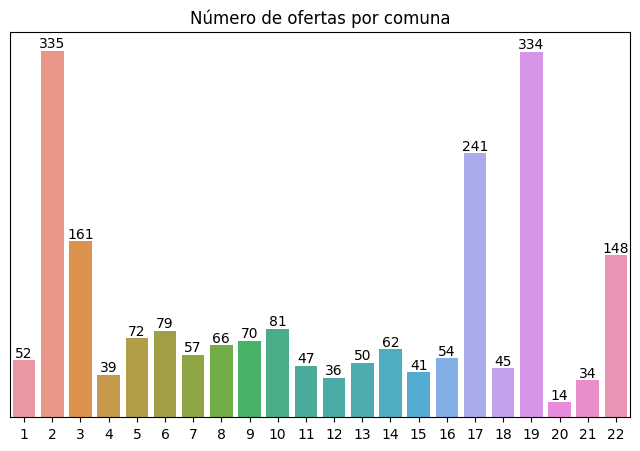

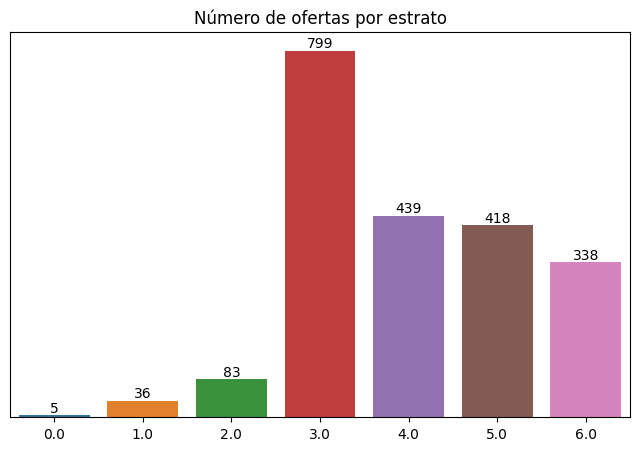

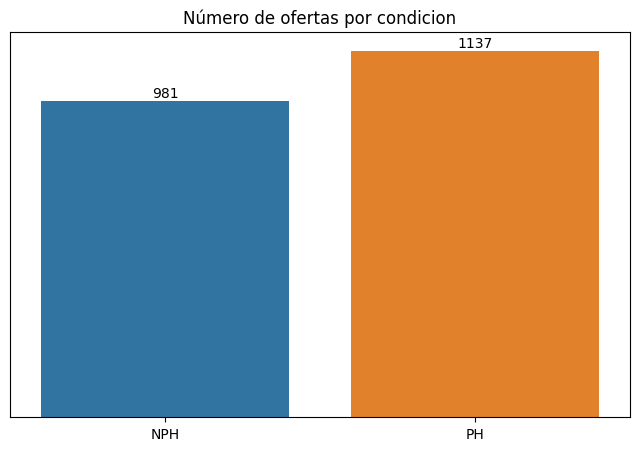

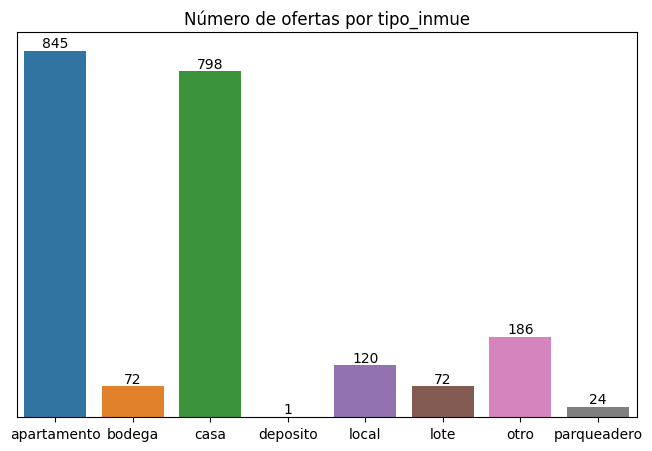

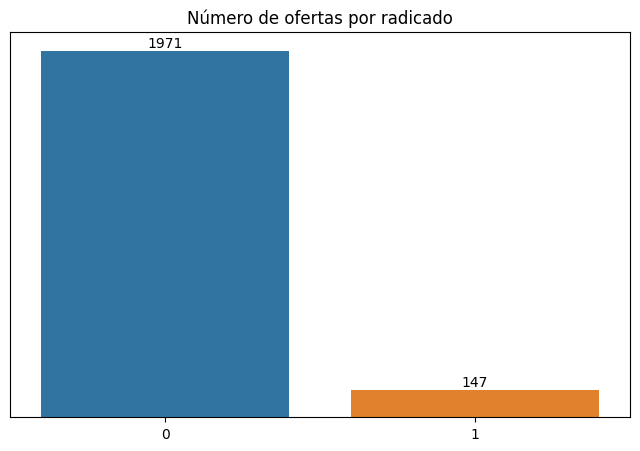

In [ ]:
 for i in columnas_categoricas:
    fig, ax = plt.subplots(figsize = (8,5))
    sns.countplot(ofertas, x = i, ax = ax, order = ofertas[i].value_counts().sort_index().index)
    ax.bar_label(ax.containers[0]) ## Muestra los valores encima de las barras
    ax.set_title(f'Número de ofertas por {i.lower()}')
    ax.set_ylabel('') ## Quita la etiqueta del eje Y
    ax.set_xlabel('') ## Quita la etiqueta del eje X
    ax.get_yaxis().set_visible(False) ##
    plt.show()

De los anteriores gráficos se puede observar que:
 - Las comunas donde se concentra la mayor cantidad de ofertas inmobiliarias son la 2, 3, 17, 19 y 22.
 - El estrato socioeconómico con mayor número de ofertas fue el 3. El Estrato 0 corresponde a los inmuebles comerciales.
 - Con respecto a la condición jurídica se tiene que se capturaron un número de ofertas similar para ambas categorías.
 - El tipo de inmueble para el que más ofertas inmobiliarias se capturaron fueron los apartamentos, seguido de las casas.
 *Teniendo en cuenta el número de ofertas por tipo de inmueble, se toma la decisión de trabajar con ofertas inmobiliarias de inmuebles habitacionales (casas y apartamentos). En gran medida, debido a que la mayoría de solicitudes de revisión de avalúo se hacen para este tipo de inmueble.

In [ ]:
ofertas = ofertas[ofertas['TIPO_INMUE'].isin(['casa','apartamento'])].copy()
ofertas_2 = ofertas.copy() ### GUARDAMOS UNA COPIA DEL DATASET EN CASO DE VOLVER A NECESITAR LOS OTROS TIPOS DE INMUEBLES
ofertas.shape

(1643, 14)

### 2.2 Análisis de variables numéricas

In [ ]:
#ofertas.select_dtypes(include = 'number').columns
columnas_numericas = [ 'VALOR_PEDI', 'AREA_CONST', 'AREA_TERRE',
       'PISOS', 'EDAD_COSNT']

In [ ]:
descr_quant = ofertas[columnas_numericas].describe()
descr_quant.loc['skew',:] = [skew(ofertas[i]) for i in columnas_numericas]
descr_quant.loc['kurtosis',:] = [kurtosis(ofertas[i]) for i in columnas_numericas]
descr_quant = descr_quant.round(2)
descr_quant.T

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
VALOR_PEDI,1643.0,4.885569e+08,6.540158e+08,40000000.0,200000000.0,320000000.0,540000000.0,1.057400e+10,7.25,81.75
AREA_CONST,1643.0,1.802400e+02,1.532200e+02,28.0,84.0,133.0,225.5,1.889000e+03,3.24,19.02
AREA_TERRE,1643.0,6.538000e+01,4.098500e+02,0.0,0.0,0.0,0.0,9.171000e+03,14.74,266.58
PISOS,1643.0,1.840000e+00,1.430000e+00,0.0,1.0,1.0,2.0,1.200000e+01,3.97,23.43
EDAD_COSNT,1643.0,8.127000e+01,3.639300e+02,0.0,0.0,11.0,22.0,2.024000e+03,5.08,23.81


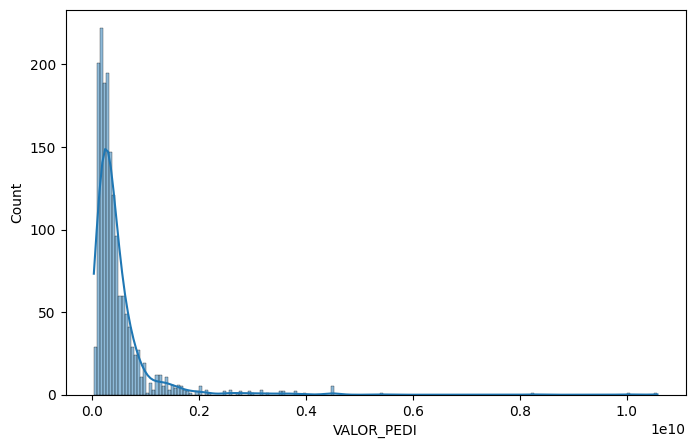

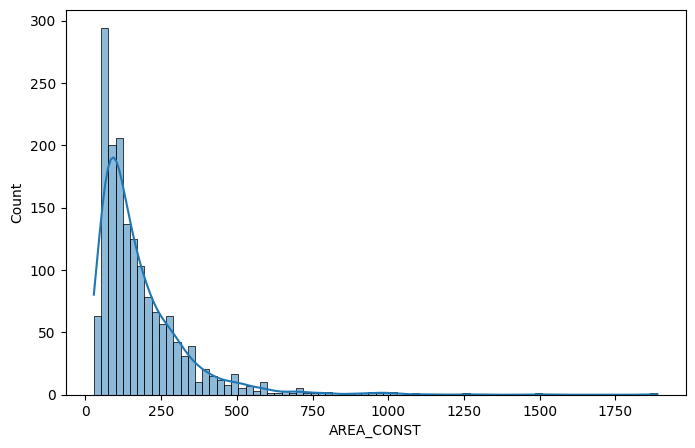

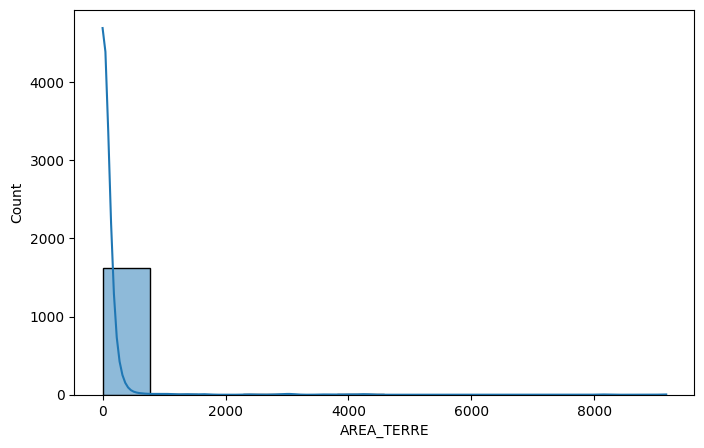

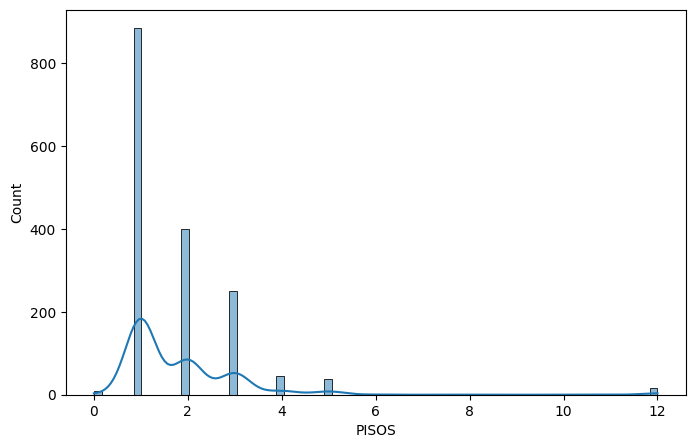

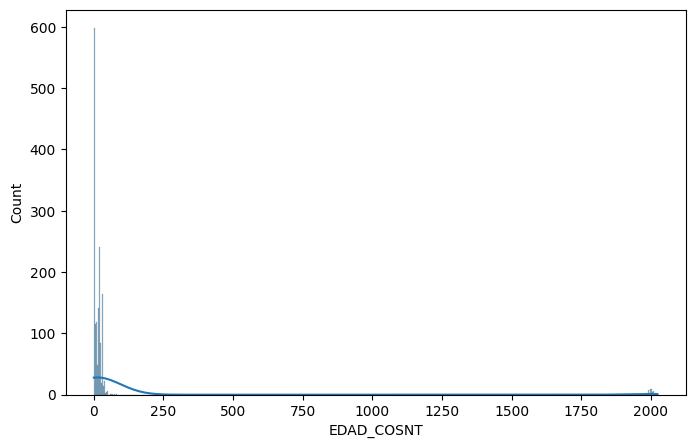

In [ ]:
for i in columnas_numericas:
    fig, ax = plt.subplots(figsize = (8,5))
    sns.histplot(ofertas[i], kde = True)
    plt.show()

En la variable edad de construcción se encontraron errores de digitación, donde en vez de colocar la edad del inmueble se colocó el año de construcción.

In [ ]:
ofertas['EDAD_COSNT'] = ofertas['EDAD_COSNT'].apply(lambda x: 2023 - x if x > 400 else x)

In [ ]:
ofertas['EDAD_COSNT'].value_counts().sort_index()

-1       1
 0     449
 1      67
 2      42
 3      42
 4      26
 5      62
 6      13
 7      19
 8      26
 9       6
 10     72
 11     17
 12     25
 13     13
 14     16
 15    121
 16     13
 17     11
 18      4
 19      7
 20    194
 21     11
 22     35
 23     13
 24      7
 25     68
 26      5
 27     14
 28      5
 29      3
 30    146
 31      9
 32     17
 33      1
 35      9
 36      3
 37      3
 38      7
 39      3
 40     13
 41      3
 42      2
 43      1
 44      1
 45      1
 46      1
 48      3
 49      1
 50      3
 51      2
 53      1
 55      1
 61      1
 67      1
 68      1
 71      1
 80      1
Name: EDAD_COSNT, dtype: int64

Una vez transformada la variable EDAD_COSNT, se observa que hay una edad negativa(es decir a la hora de hacer la transformación se había digitado 2024), se le imputa un cero. Por otra parte, se observa que hay 450 inmuebles que tienen una edad de construcción 0, por conocimiento de la dinámica inmobiliria de la ciudad se puede considerar un error de digitación en aquellos inmuebles de condición NPH. Se realizará una imputación a los predios NPH que tengan una edad de construcción 0.

In [ ]:
ofertas.loc[ofertas['EDAD_COSNT']==-1,'EDAD_COSNT'] = 0

La separación de las ofertas por condición del inmueble, se realiza porque los inmuebles en condición PH se valoran de una manera distinta a los inmuebles en condición NPH

Se separa el dataset en PH y NPH

In [ ]:
ph = ofertas[ofertas['CONDICION']=='PH']
ph.drop(labels = ['CONDICION','PISOS','AREA_TERRE'], axis = 1, inplace = True)
nph = ofertas[ofertas['CONDICION']=='NPH']
nph.drop(labels = ['CONDICION','PISOS'], axis = 1, inplace = True)

<ipython-input-16-f5a11d30e43e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ph.drop(labels = ['CONDICION','PISOS','AREA_TERRE'], axis = 1, inplace = True)
<ipython-input-16-f5a11d30e43e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nph.drop(labels = ['CONDICION','PISOS'], axis = 1, inplace = True)


### 2.3 Detección y tratamiento de outliers

#### Predios condición PH

In [ ]:
ph[['VALOR_PEDI','AREA_CONST','EDAD_COSNT', 'LAT', 'LONG']].describe().T

,count,mean,std,min,25%,50%,75%,max
VALOR_PEDI,932.0,4.322031e+08,3.811901e+08,7.600000e+07,1.772500e+08,3.200000e+08,5.500000e+08,3.500000e+09
AREA_CONST,932.0,1.201184e+02,9.034307e+01,2.800000e+01,6.500000e+01,9.450000e+01,1.380000e+02,1.000000e+03
EDAD_COSNT,932.0,1.042704e+01,1.035109e+01,0.000000e+00,1.000000e+00,8.000000e+00,1.825000e+01,4.900000e+01
LAT,932.0,3.425242e+00,4.547153e-02,3.333400e+00,3.385607e+00,3.428749e+00,3.463775e+00,3.498653e+00
LONG,932.0,-7.653020e+01,1.938420e-02,-7.656423e+01,-7.654783e+01,-7.653106e+01,-7.651872e+01,-7.646699e+01


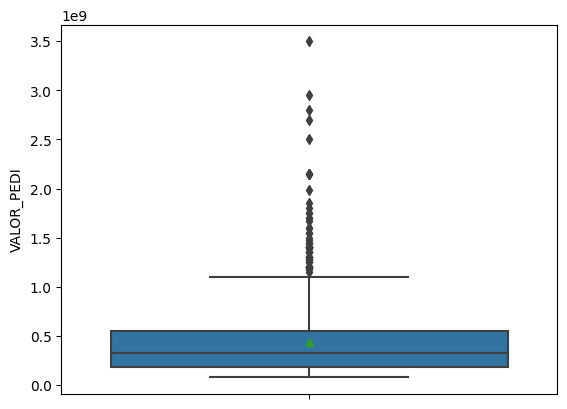

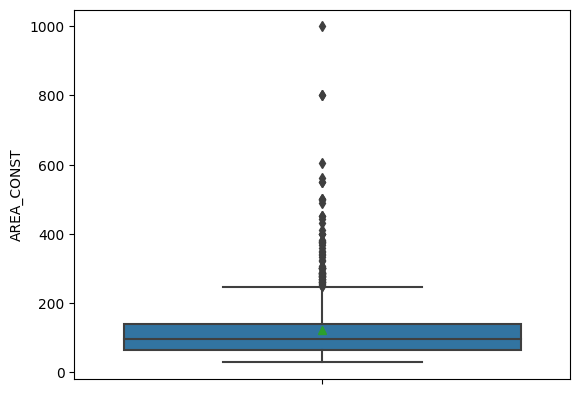

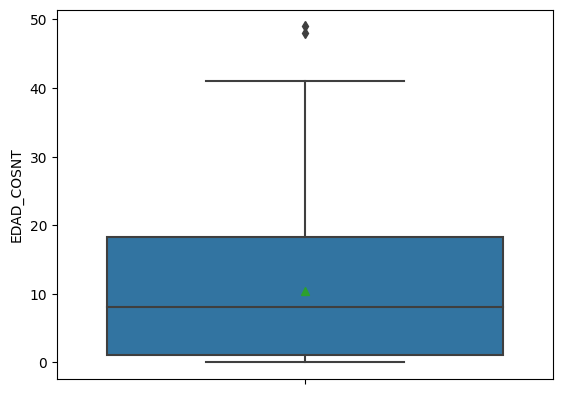

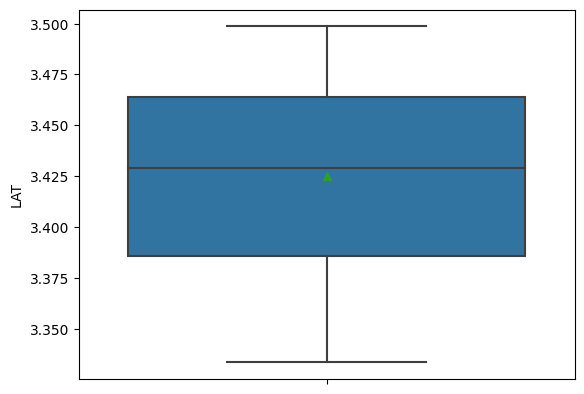

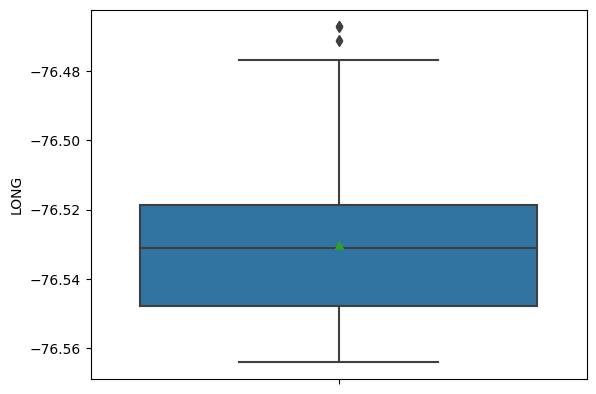

In [ ]:
for i in ['VALOR_PEDI','AREA_CONST','EDAD_COSNT', 'LAT', 'LONG']:
  plt.figure()
  sns.boxplot(data = ph, y = i, showmeans = True, hue = 'TIPO_INMUE')
  plt.show()

Para la eliminación de predios atípicos se utilizará la siguiente regla:
- Si el tipo de predio es apartamento y condición jurídica PH, entonces área de construcción debe ser menor o igual a 350 m2.
- Si el tipo de predio es casa y condición jurídica PH, entonces área de construcción debe ser menor o igual a 800 m2

In [ ]:
ph = ph[((ph['TIPO_INMUE']=='apartamento')&(ph['AREA_CONST']<=350))|((ph['TIPO_INMUE']=='casa')&(ph['AREA_CONST']<=800))]

#### Predios NPH
Se emplea una imputación por KNN imputer a los predios con edad cero

Se convierte en np.nan las ofertas que tienen 0 como edad

In [ ]:
nph.loc[nph['EDAD_COSNT']==0,'EDAD_COSNT'] = np.nan

Llamamos el KNNImputer

In [ ]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer()
nph[['EDAD_COSNT','LAT','LONG','AREA_CONST']] = knn_imputer.fit_transform(nph[['EDAD_COSNT','LAT','LONG','AREA_CONST']])

<ipython-input-19-d4a7d96af7ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nph[['EDAD_COSNT','LAT','LONG','AREA_CONST']] = knn_imputer.fit_transform(nph[['EDAD_COSNT','LAT','LONG','AREA_CONST']])


In [ ]:
nph['EDAD_COSNT'].value_counts().sort_index()

1.0     4
2.0     3
4.0     2
5.0     5
6.0     1
       ..
61.0    1
67.0    1
68.0    1
71.0    1
80.0    1
Name: EDAD_COSNT, Length: 104, dtype: int64

Como se observa en la salida de la anterior celda ya se realizó la imputación de los valores.

In [ ]:
nph[['VALOR_PEDI','AREA_CONST','AREA_TERRE','EDAD_COSNT', 'LAT', 'LONG']].describe().T

,count,mean,std,min,25%,50%,75%,max
VALOR_PEDI,711.0,5.624273e+08,8.882839e+08,4.000000e+07,2.225000e+08,3.300000e+08,5.225000e+08,1.057400e+10
AREA_CONST,711.0,2.590408e+02,1.806407e+02,3.900000e+01,1.500000e+02,2.100000e+02,3.107250e+02,1.889000e+03
AREA_TERRE,711.0,1.356427e+02,6.125925e+02,0.000000e+00,0.000000e+00,0.000000e+00,1.080000e+02,9.171000e+03
EDAD_COSNT,711.0,2.427707e+01,8.936150e+00,1.000000e+00,2.000000e+01,2.300000e+01,3.000000e+01,8.000000e+01
LAT,711.0,3.433180e+00,3.222824e-02,3.333615e+00,3.416777e+00,3.433871e+00,3.448998e+00,3.500412e+00
LONG,711.0,-7.651214e+01,2.379711e-02,-7.658929e+01,-7.653206e+01,-7.651184e+01,-7.649342e+01,-7.646188e+01


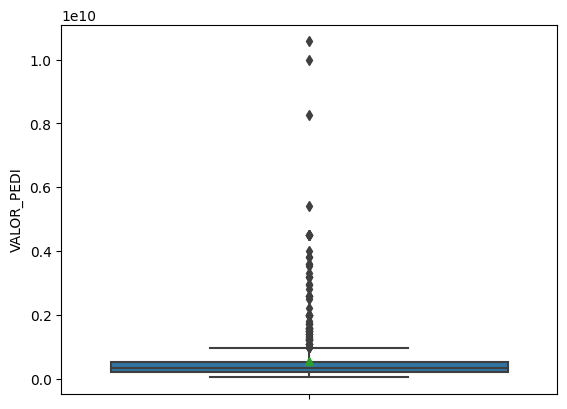

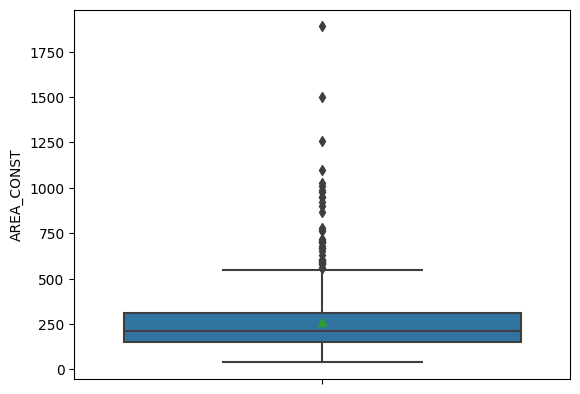

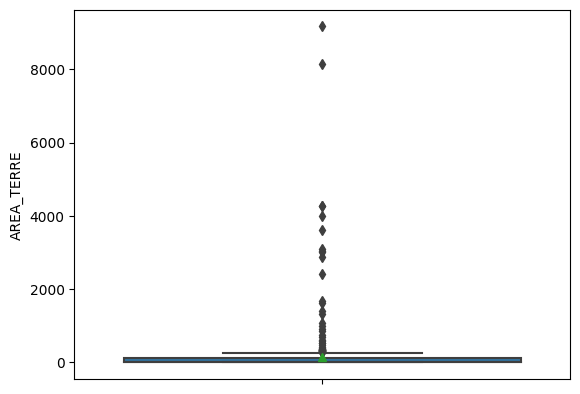

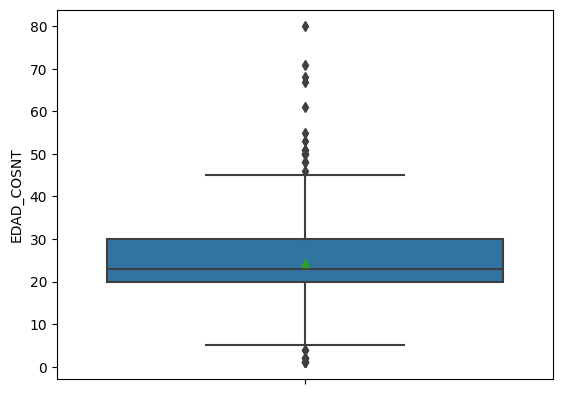

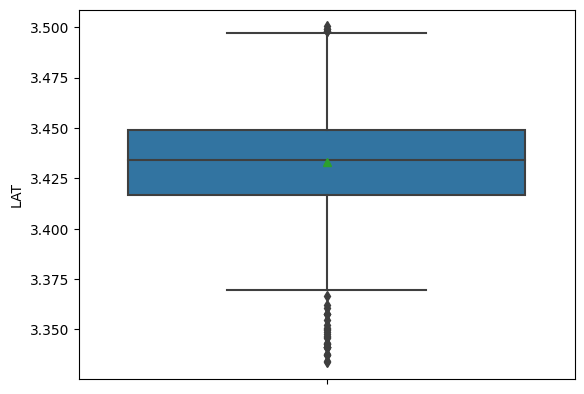

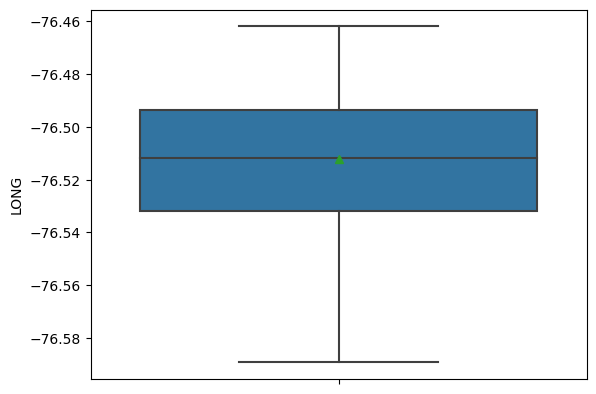

In [ ]:
for i in ['VALOR_PEDI','AREA_CONST','AREA_TERRE','EDAD_COSNT', 'LAT', 'LONG']:
  plt.figure()
  sns.boxplot(data = nph, y = i, showmeans = True)
  plt.show()

Para la eliminación de predios atípicos se utilizará la siguiente regla:
- Se elimina la oferta que tenga un área de terreno mayor a 5.000 m2

In [ ]:
nph = nph[nph['AREA_TERRE'] <= 5000]

### 2.4 Análisis bivariado

Para ver el comportamiento de la variable valor pedido por comunas se cargará un shape con las comunas de Cali.

In [ ]:
comunas = gpd.read_file('/vsicurl/https://github.com/HanisDad95/TalleresMSc/raw/main/Shapes/COMUNAS.shp').to_crs(epsg = 4326)
comunas['COMUNA'] = comunas['COMUNA'].astype('int') ### Se transforma a entero para que funcioné el join con el df de ofertas

In [ ]:
ph_conteo = pd.DataFrame(ph.groupby('COMUNA')['VALOR_PEDI'].median().reset_index())
nph_conteo = pd.DataFrame(nph.groupby('COMUNA')['VALOR_PEDI'].median().reset_index())

In [ ]:
comunas = comunas.merge(ph_conteo, on = 'COMUNA', suffixes = (None, '_ph')).merge(nph_conteo, on = 'COMUNA', suffixes = ('_ph', '_nph'))

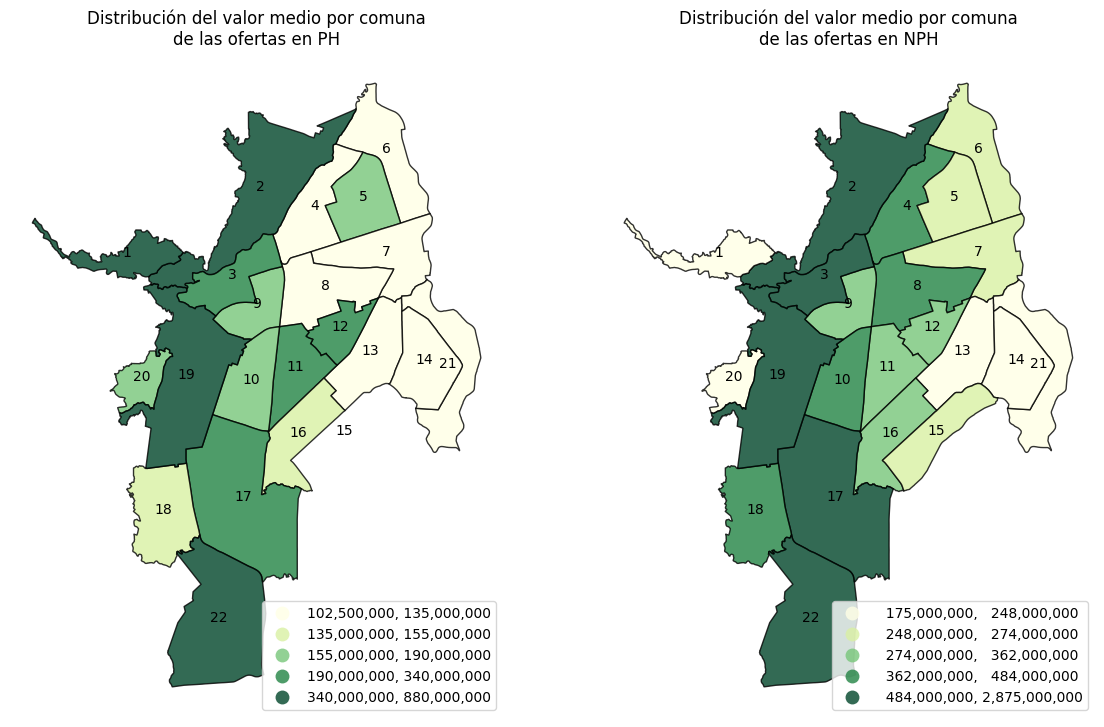

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (14,10))
ax1.set_title('Distribución del valor medio por comuna\nde las ofertas en PH')
comunas.plot(
    ax = ax1,
    edgecolor="black",
    alpha = 0.8,
    scheme="quantiles",
    k = 5,
    column='VALOR_PEDI_ph',
    cmap="YlGn",
    legend=True,
    legend_kwds={'loc':'lower right',
                 "fmt": "{:,.0f}"}
    )
comunas.apply(lambda x: ax1.annotate(text=int(x['COMUNA']), xy=x.geometry.centroid.coords[0], ha='center'),axis=1)
ax1.set_axis_off()
ax2.set_title('Distribución del valor medio por comuna\nde las ofertas en NPH')
comunas.plot(
    ax = ax2,
    edgecolor="black",
    scheme="quantiles",
    k = 5,
    alpha = 0.8,
    column='VALOR_PEDI_nph',
    cmap="YlGn",
    legend=True,
    legend_kwds={'loc':'lower right',
                 "fmt": "{:,.0f}"}
    )
comunas.apply(lambda x: ax2.annotate(text=int(x['COMUNA']), xy=x.geometry.centroid.coords[0], ha='center'),axis=1)
ax2.set_axis_off()

Se debe convertir el dataframe a un geodataframe para realizar los mapas

In [ ]:
ofertas_geo = gpd.GeoDataFrame(ofertas, geometry = gpd.points_from_xy(ofertas.LONG, ofertas.LAT), crs = 4326)

In [ ]:
m = ofertas_geo[['VALOR_PEDI','geometry']].explore(color = 'gray', legend = False, name = 'Ofertas', zoom_start = 12)
HeatMap(list(zip(ofertas_geo['LAT'],ofertas_geo['LONG'],ofertas_geo['VALOR_PEDI'])), name = 'Mapa de calor').add_to(m)
folium.LayerControl().add_to(m)
m

<Axes: >

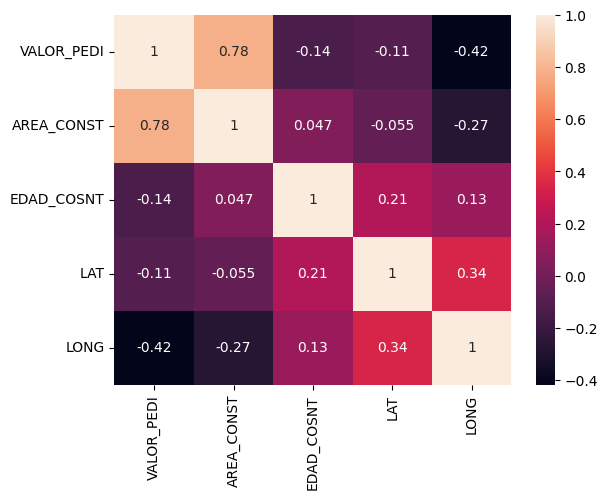

In [ ]:
sns.heatmap(ph.drop('OBJECTID', axis = 1).corr(numeric_only = True), annot = True)

<Axes: >

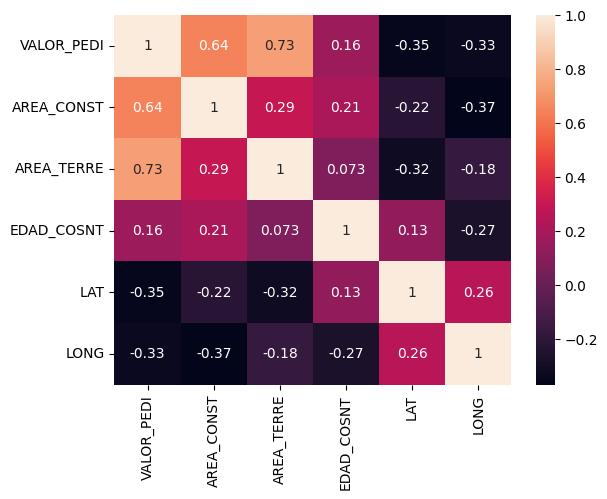

In [ ]:
sns.heatmap(nph.drop('OBJECTID', axis = 1).corr(numeric_only = True), annot = True)

Con el análsis bivariado entre la variable (Valor pedido) de la ofertas inmobiliarias y las variables que representan características físicas y de ubicación del predio tales como el área de terreno, el área de construcción y las coordenadas (x,y) son variables que generan diferenciación entre los precios de los inmuebles.

### Feature Engineering

En vista de que no se tienen muchas variables, se puede crear una variable, en las siguiente lineas se realiza el cálculo de la distancia de cada oferta a la estación del SITM más cercana.

In [ ]:
estaciones = gpd.read_file("/vsicurl/https://github.com/HanisDad95/TalleresMSc/raw/main/Shapes/mov_sitm_estaciones.shp").to_crs(epsg = 4326)

In [ ]:
## SE DEBEN REPROYECTAR LA CAPA PARA QUE LA DISTANCIA ENTRE LA OFERTA Y LA ESTACIÓN DEL SITM SEA EN METROS.
ofertas_geo = ofertas_geo.to_crs(crs=3857)
estaciones = estaciones.to_crs(crs=3857)

ofertas_geo = ofertas_geo.sjoin_nearest(estaciones[['geometry','ESTACION']], distance_col = 'Dist_estacion')
ph_geo = ofertas_geo[ofertas_geo['CONDICION']=='PH']
ph_geo.drop(labels = 'CONDICION', axis = 1, inplace = True)
nph_geo = ofertas_geo[ofertas_geo['CONDICION']=='NPH']
nph_geo.drop(labels = 'CONDICION', axis = 1, inplace = True)

<ipython-input-44-1116123ef608>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ph_geo.drop(labels = 'CONDICION', axis = 1, inplace = True)
<ipython-input-44-1116123ef608>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nph_geo.drop(labels = 'CONDICION', axis = 1, inplace = True)


# 3. Modelo no supervisado para la creación de clúster.


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import ward  # Importa la función 'ward' desde scipy

In [ ]:
ph.head()

,OBJECTID,COMUNA,TIPO_INMUE,ESTRATO,VALOR_PEDI,AREA_CONST,EDAD_COSNT,FECHA_OFER,LAT,LONG,RADICADO
8,9,22,apartamento,6.0,1450000000,212.0,2,2022-03-02,3.342467,-76.548489,0
12,13,17,casa,3.0,280000000,142.0,38,2022-03-02,3.409454,-76.538520,0
13,14,2,casa,4.0,450000000,264.0,0,2022-03-02,3.476946,-76.517191,0
17,18,1,apartamento,1.0,120000000,58.0,1,2022-03-04,3.459751,-76.560919,1
25,26,19,casa,5.0,435000000,373.0,40,2022-04-18,3.437929,-76.540484,0


3.1 Clustering para predios con condición PH
Las variables que caracterizarán los clúster de los predios con condición PH son:
Área de construcción,
Edad del predio,
Coordenadas (Latitud y Longitud)

In [ ]:
def encontrar_numero_clusters(X):
    # Crea una lista vacía para almacenar la inercia
    inertia = []

    # Prueba diferentes números de clusters de 1 a N
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)

    # Calcula la inercia acumulada
    inertia_cumulative = np.cumsum(inertia)

    # Calcula el porcentaje de la inercia acumulada
    total_inertia = inertia_cumulative[-1]
    inertia_percentage = (inertia_cumulative / total_inertia) * 100

    # Encuentra el número de clusters que recoja el 90% de la inercia
    n_clusters_95_percent = np.argmax(inertia_percentage >= 95) + 1

    # Visualiza la curva de la inercia acumulada
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, 11), inertia_percentage, marker='o', linestyle='--')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Inercia Acumulada (%)')
    plt.title('Curva de Codo')
    plt.grid(True)
    plt.show()

    print(f"Número de clusters que recoja el 95% de la inercia: {n_clusters_95_percent}")

    return n_clusters_95_percent



# Ejemplo de uso:
# Supongamos que tienes tus datos en la matriz X
# encontrar_numero_clusters(X)

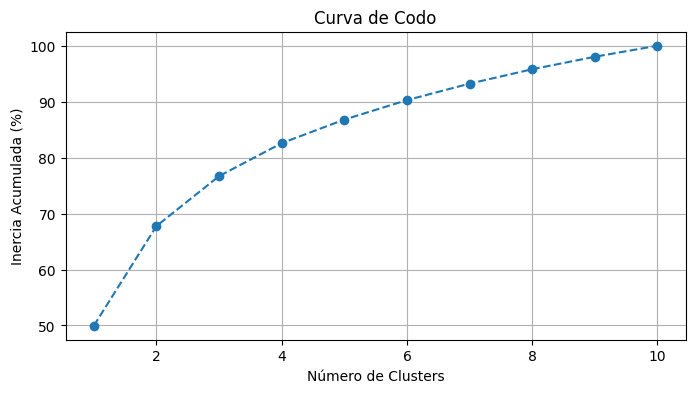

Número de clusters que recoja el 95% de la inercia: 8


<ipython-input-27-1ca733dacb24>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ph_tipo['CLUSTER'] = labels_ph_tipo


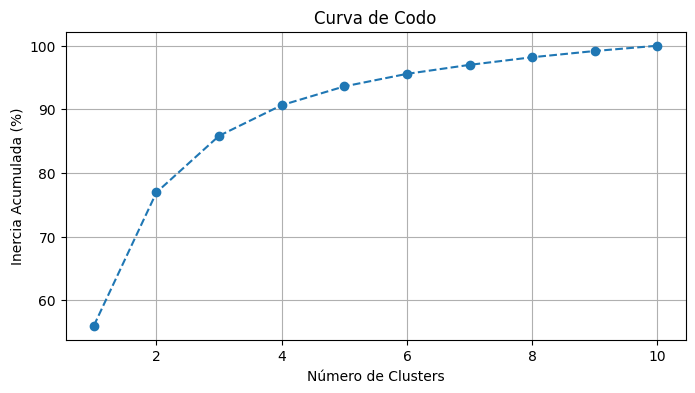

Número de clusters que recoja el 95% de la inercia: 6


<ipython-input-27-1ca733dacb24>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ph_tipo['CLUSTER'] = labels_ph_tipo


In [ ]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.cluster._kmeans")

resultado = pd.DataFrame()

for j in (ph['TIPO_INMUE']).unique():

  ph_tipo = ph[ph['TIPO_INMUE'] == j]
  X_ph= np.array(ph_tipo[['AREA_CONST', 'EDAD_COSNT', 'LAT', 'LONG']])
  k = encontrar_numero_clusters(X_ph)#es el número de cluster calculado con la funcion

  #Ajustar el modelo para calculo de cluster
  cluster = KMeans(n_clusters = k, random_state = 123)
  cluster.fit(X_ph)
  labels_ph_tipo = cluster.predict(X_ph)
  ph_tipo['CLUSTER'] = labels_ph_tipo

  resultado = pd.concat([resultado, ph_tipo])



In [ ]:
resultado.shape

(917, 12)

In [ ]:
resultado

,OBJECTID,COMUNA,TIPO_INMUE,ESTRATO,VALOR_PEDI,AREA_CONST,EDAD_COSNT,FECHA_OFER,LAT,LONG,RADICADO,CLUSTER
8,9,22,apartamento,6.0,1450000000,212.0,2,2022-03-02,3.342467,-76.548489,0,1
17,18,1,apartamento,1.0,120000000,58.0,1,2022-03-04,3.459751,-76.560919,1,6
26,27,22,apartamento,6.0,710000000,167.0,12,2022-04-01,3.337628,-76.531150,0,4
27,28,17,apartamento,6.0,345000000,95.0,3,2022-04-02,3.367518,-76.515796,0,0
28,29,19,apartamento,5.0,322000000,75.0,15,2022-04-19,3.409791,-76.550536,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3340,3447,13,casa,2.0,139000000,108.0,30,2022-06-16,3.433338,-76.494650,0,5
3357,3470,19,casa,4.0,350000000,150.0,13,2022-03-30,3.397860,-76.552105,0,1
3411,3525,16,casa,1.0,280000000,226.0,25,2022-05-13,3.413547,-76.503840,0,3
3453,3571,22,casa,6.0,2800000000,800.0,2,2022-02-24,3.352582,-76.545678,0,2


In [ ]:
resultado.dtypes

OBJECTID               int64
COMUNA              category
TIPO_INMUE          category
ESTRATO             category
VALOR_PEDI             int64
AREA_CONST           float64
EDAD_COSNT             int64
FECHA_OFER    datetime64[ns]
LAT                  float64
LONG                 float64
RADICADO            category
CLUSTER                int32
dtype: object

In [ ]:
resultado['CLUSTER'] = resultado['CLUSTER'].astype('category')

In [ ]:
resultado['Grupo'] = resultado['TIPO_INMUE'].astype(str) + '_' + resultado['CLUSTER'].astype(str)


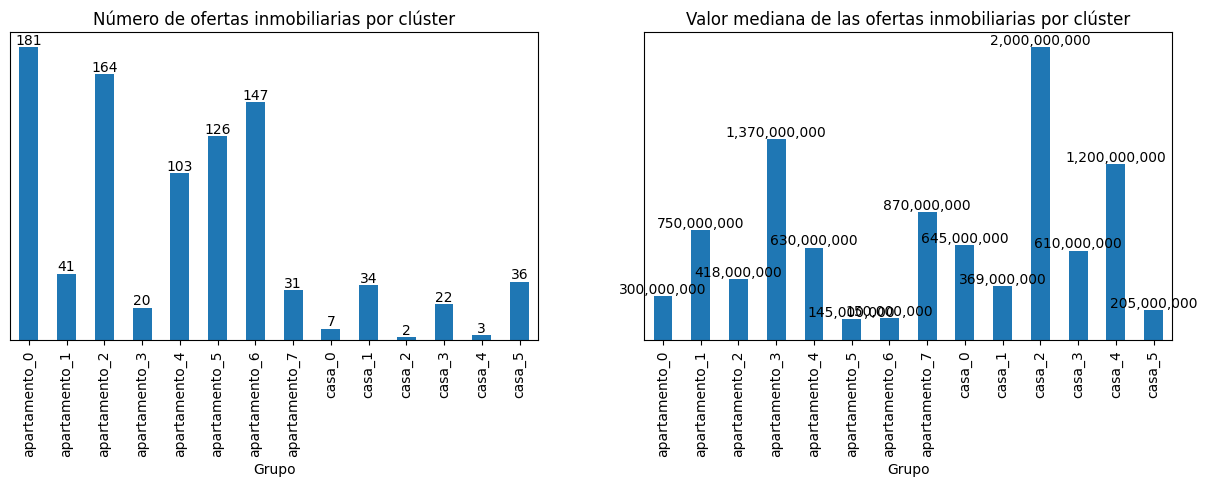

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (15,4))
resultado.groupby('Grupo').size().sort_index().plot(kind = 'bar', ax = ax1)
ax1.bar_label(ax1.containers[0])
ax1.get_yaxis().set_visible(False) ##
ax1.set_title('Número de ofertas inmobiliarias por clúster')
ax2 = resultado.groupby('Grupo')['VALOR_PEDI'].median().sort_index().plot(kind = 'bar', ax = ax2)
ax2.bar_label(ax2.containers[0], fmt='{:,.0f}')
ax2.get_yaxis().set_visible(False) ##
ax2.set_title('Valor mediana de las ofertas inmobiliarias por clúster')
plt.show()


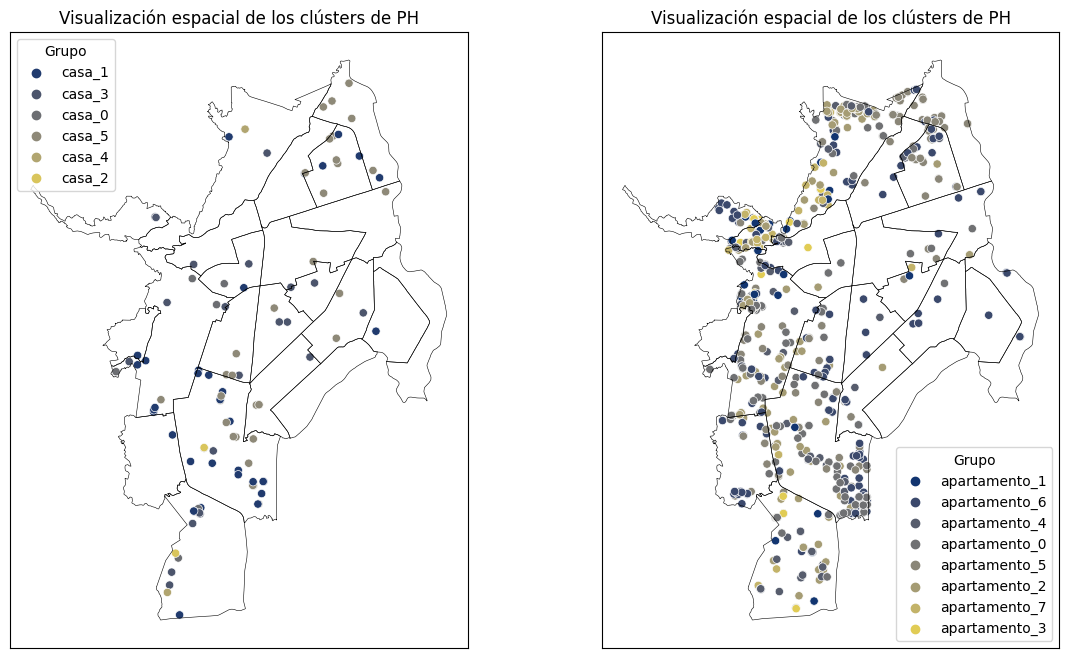

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2 ,figsize = (14,8))
sns.scatterplot(resultado[resultado['TIPO_INMUE']=='casa'], x = 'LONG', y = 'LAT', hue = 'Grupo', palette = 'cividis', ax = ax1)
comunas.boundary.plot(edgecolor = 'black', linewidth = 0.4, ax = ax1)
ax1.get_yaxis().set_visible(False) ##
ax1.get_xaxis().set_visible(False) ##
ax1.set_title('Visualización espacial de los clústers de PH')
sns.scatterplot(resultado[resultado['TIPO_INMUE']=='apartamento'], x = 'LONG', y = 'LAT', hue = 'Grupo', palette = 'cividis', ax = ax2)
comunas.boundary.plot(edgecolor = 'black', linewidth = 0.4, ax = ax2)
ax2.get_yaxis().set_visible(False) ##
ax2.get_xaxis().set_visible(False) ##
ax2.set_title('Visualización espacial de los clústers de PH')
plt.show()

####Intervalos de confiabilidad a partir de la distribución de probabilidad de la variable (Valor pedido)
3.3 Creación de intervalos de confiabilidad con el valor pedido de las ofertas inmobiliarias, para comparar si los predios radicados que estan dentro del mismo clúster estan o no dentro del intervalo.

In [ ]:
from pandas.core.groupby import groupby
### Intervalos de confidencialidad

ofertas_ph = resultado[resultado['RADICADO']==0]
limite_inf = ofertas_ph.groupby('Grupo')['VALOR_PEDI'].quantile(0.05)
limite_sup = ofertas_ph.groupby('Grupo')['VALOR_PEDI'].quantile(0.95)
resultado['Limite_inf'] = resultado['Grupo'].map(limite_inf)
resultado['Limite_sup'] = resultado['Grupo'].map(limite_sup)


In [ ]:
resultado.head()

,OBJECTID,COMUNA,TIPO_INMUE,ESTRATO,VALOR_PEDI,AREA_CONST,EDAD_COSNT,FECHA_OFER,LAT,LONG,RADICADO,CLUSTER,Grupo,Limite_inf,Limite_sup
8,9,22,apartamento,6.0,1450000000,212.0,2,2022-03-02,3.342467,-76.548489,0,1,apartamento_1,407500000.0,1.355475e+09
17,18,1,apartamento,1.0,120000000,58.0,1,2022-03-04,3.459751,-76.560919,1,6,apartamento_6,86300000.0,2.700000e+08
26,27,22,apartamento,6.0,710000000,167.0,12,2022-04-01,3.337628,-76.531150,0,4,apartamento_4,248000000.0,9.012264e+08
27,28,17,apartamento,6.0,345000000,95.0,3,2022-04-02,3.367518,-76.515796,0,0,apartamento_0,177000000.0,4.900000e+08
28,29,19,apartamento,5.0,322000000,75.0,15,2022-04-19,3.409791,-76.550536,0,0,apartamento_0,177000000.0,4.900000e+08


In [ ]:
pd.options.display.float_format = '{:.2f}'.format
resultado.groupby('Grupo')['Limite_inf','Limite_sup'].first()

3.2 Clustering para predios con condición NPH Las variables que caracterizarán los clúster de los predios con condición PH son: Área de terreno, Área de construcción, Edad del predio, Coordenadas (Latitud y Longitud)

casa


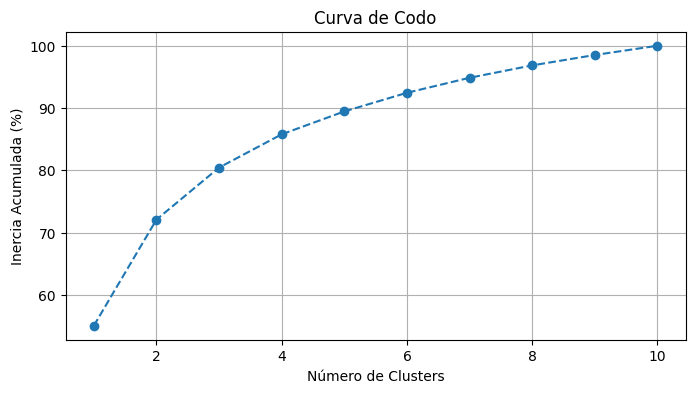

Número de clusters que recoja el 95% de la inercia: 8
apartamento


<ipython-input-60-4a43e5272766>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nph_tipo['CLUSTER'] = labels_nph_tipo


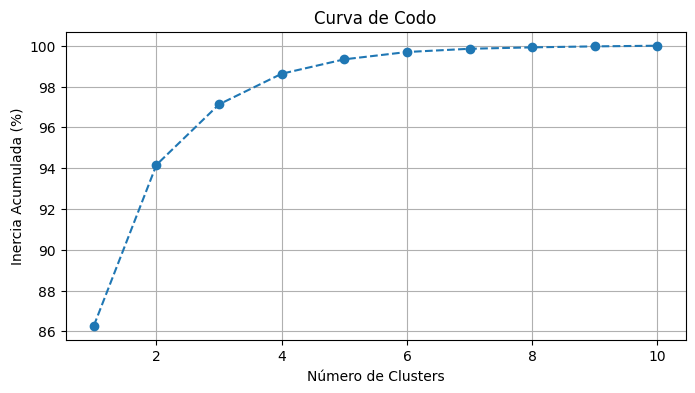

Número de clusters que recoja el 95% de la inercia: 3


<ipython-input-60-4a43e5272766>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nph_tipo['CLUSTER'] = labels_nph_tipo


In [ ]:
#Estimar los cluster para los predios NPH
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.cluster._kmeans")

resultado_nph = pd.DataFrame()

for j in (nph['TIPO_INMUE']).unique():
  print(j)
  nph_tipo = nph[nph['TIPO_INMUE'] == j]
  X_nph= np.array(nph_tipo[['AREA_CONST','AREA_TERRE', 'EDAD_COSNT', 'LAT', 'LONG']])
  k = encontrar_numero_clusters(X_nph)#es el número de cluster calculado con la funcion

  #Ajustar el modelo para calculo de cluster
  cluster = KMeans(n_clusters = k, random_state = 123)
  cluster.fit(X_nph)
  labels_nph_tipo = cluster.predict(X_nph)
  nph_tipo['CLUSTER'] = labels_nph_tipo

  resultado_nph = pd.concat([resultado_nph, nph_tipo])

In [ ]:
resultado_nph['CLUSTER'] = resultado_nph['CLUSTER'].astype('category')

In [ ]:
resultado_nph['Grupo'] = resultado_nph['TIPO_INMUE'].astype(str) + '_' + resultado_nph['CLUSTER'].astype(str)

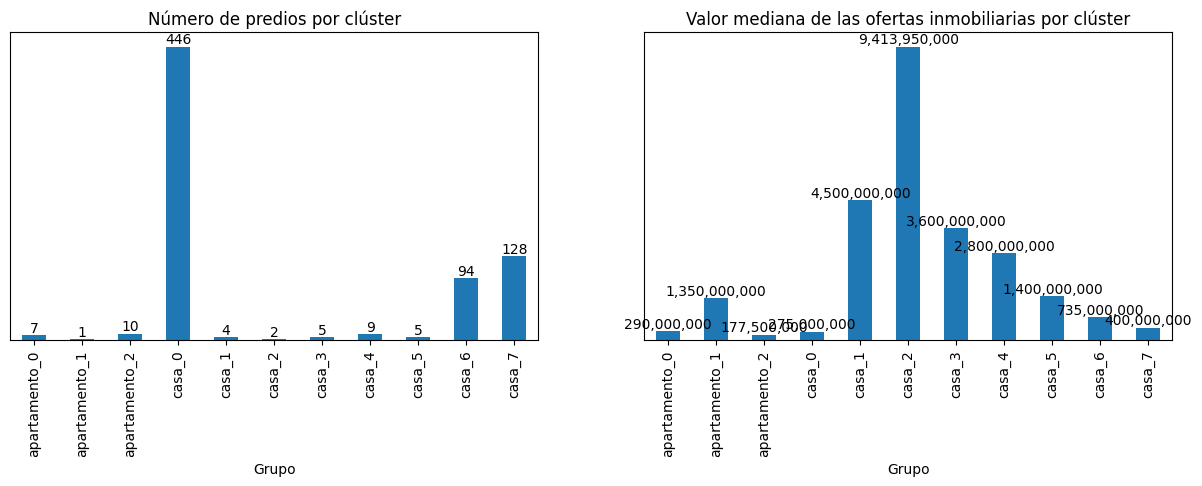

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (15,4))
resultado_nph.groupby('Grupo').size().sort_index().plot(kind = 'bar', ax = ax1)
ax1.bar_label(ax1.containers[0])
ax1.get_yaxis().set_visible(False) ##
ax1.set_title('Número de predios por clúster')
ax2 = resultado_nph.groupby('Grupo')['VALOR_PEDI'].median().sort_index().plot(kind = 'bar', ax = ax2)
ax2.bar_label(ax2.containers[0], fmt='{:,.0f}')
ax2.get_yaxis().set_visible(False) ##
ax2.set_title('Valor mediana de las ofertas inmobiliarias por clúster')
plt.show()

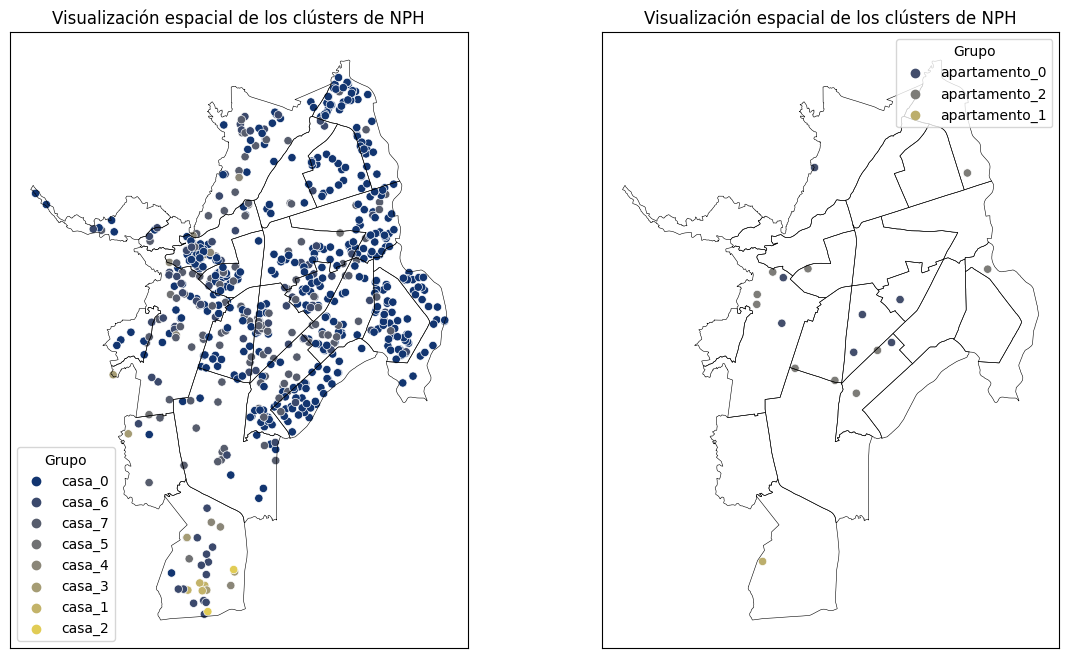

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (14,8))
sns.scatterplot(resultado_nph[resultado_nph['TIPO_INMUE']=='casa'], x = 'LONG', y = 'LAT', hue = 'Grupo', palette = 'cividis', ax = ax1)
comunas.boundary.plot(edgecolor = 'black', linewidth = 0.4, ax = ax1)
ax1.get_yaxis().set_visible(False) ##
ax1.get_xaxis().set_visible(False) ##
ax1.set_title('Visualización espacial de los clústers de NPH')
sns.scatterplot(resultado_nph[resultado_nph['TIPO_INMUE']=='apartamento'], x = 'LONG', y = 'LAT', hue = 'Grupo', palette = 'cividis', ax = ax2)
comunas.boundary.plot(edgecolor = 'black', linewidth = 0.4, ax = ax2)
ax2.get_yaxis().set_visible(False) ##
ax2.get_xaxis().set_visible(False) ##
ax2.set_title('Visualización espacial de los clústers de NPH')
plt.show()

In [ ]:
from pandas.core.groupby import groupby
### Intervalos de confidencialidad

ofertas_nph = resultado_nph[resultado_nph['RADICADO']==0]
limite_inf = ofertas_nph.groupby('Grupo')['VALOR_PEDI'].quantile(0.05)
limite_sup = ofertas_nph.groupby('Grupo')['VALOR_PEDI'].quantile(0.95)
resultado_nph['Limite_inf'] = resultado_nph['Grupo'].map(limite_inf)
resultado_nph['Limite_sup'] = resultado_nph['Grupo'].map(limite_sup)

In [ ]:
resultado_nph.head()

,OBJECTID,COMUNA,TIPO_INMUE,ESTRATO,VALOR_PEDI,AREA_CONST,AREA_TERRE,EDAD_COSNT,FECHA_OFER,LAT,LONG,RADICADO,CLUSTER,Grupo,Limite_inf,Limite_sup
0,1,3,casa,5.00,226000000,226.00,0.00,27.40,2022-02-22,3.45,-76.54,0,0,casa_0,129700000.00,586000000.00
1,2,3,casa,5.00,995000000,517.00,0.00,27.40,2022-02-22,3.45,-76.54,1,6,casa_6,304000000.00,3080000000.00
3,4,3,casa,3.00,280000000,275.00,0.00,43.60,2022-02-22,3.45,-76.53,0,0,casa_0,129700000.00,586000000.00
5,6,7,casa,3.00,255000000,160.00,133.00,55.00,2022-03-01,3.46,-76.49,1,0,casa_0,129700000.00,586000000.00
6,7,2,casa,5.00,1240000000,455.00,467.76,30.00,2022-02-28,3.48,-76.52,1,7,casa_7,192000000.00,1353200000.00


In [ ]:
valores_referencia_nph = resultado_nph.groupby('Grupo')['Limite_inf','Limite_sup'].first().reset_index()

<ipython-input-71-24ad747b1aa0>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  valores_referencia_nph = resultado_nph.groupby('Grupo')['Limite_inf','Limite_sup'].first().reset_index()


Se vuelven a inicializar los cluster, puesto que el bucle en el que se encontró el K óptimo no quedaron guardados.

In [ ]:
NPH_apto_clus = KMeans(n_clusters = 3, random_state = 123)
NPH_apto_clus.fit(np.array(nph[nph['TIPO_INMUE']=='apartamento'][['AREA_CONST','AREA_TERRE', 'EDAD_COSNT', 'LAT', 'LONG']]))
NPH_casa_clus = KMeans(n_clusters = 8, random_state = 123)
NPH_casa_clus.fit(np.array(nph[nph['TIPO_INMUE']=='casa'][['AREA_CONST','AREA_TERRE', 'EDAD_COSNT', 'LAT', 'LONG']]))

KMeans(random_state=123)

In [ ]:
def revision_predio(tipo_inmue : str, area_const : float , area_terre : float,
                    edad_const :float, lat : float, long : float, valor_liquidado : float):
  '''
  Función que toma como variables de entrada las variables físicas del predio sujeto a revisión y su avalúo liquidado.
  Utiliza los clústers previamente entrenados para predecir de acuerdo a sus características físicas.
  ------
  Returns : Recomendación al equipo de avalúos si se sugiere revisar el avalúo o no.
  '''
  predio = pd.DataFrame([[area_const,area_terre, edad_const,lat, long]], columns = ['AREA_CONST','AREA_TERRE', 'EDAD_COSNT', 'LAT', 'LONG'])
  if tipo_inmue == 'casa':
    predio['cluster'] = NPH_casa_clus.predict(predio)
    predio['valor_liq'] = valor_liquidado
    predio['grupo'] = tipo_inmue + '_' + predio['cluster'].astype(str)

  elif tipo_inmue == 'apartamento':
    predio['cluster'] = NPH_apto_clus.predict(predio)
    predio['valor_liq'] = valor_liquidado
    predio['grupo'] = tipo_inmue + '_' + predio['cluster'].astype(str)

  if (predio['valor_liq'].values[0] > valores_referencia_nph[valores_referencia_nph['Grupo']==predio['grupo'][0]]['Limite_sup'].values[0]) or\
     (predio['valor_liq'].values[0] < valores_referencia_nph[valores_referencia_nph['Grupo']==predio['grupo'][0]]['Limite_inf'].values[0]) :
    return 'El predio debe ser revisado por el equipo de revisión de avalúos, puesto que el valor liquidado no se ajusta a los valores comerciales observados'
  else:
    return 'La liquidación del predio está dentro de los precios observados en el mercado inmobiliario para predios de características físicas similares'


Una prueba de cómo utilizaría esta herramienta un avaluador en la Subdirección de catastro

In [ ]:
revision_predio(tipo_inmue = 'casa', area_const = 516 , area_terre = 0,
                edad_const = 27, lat = 3.446850, long = -76.542233,
                valor_liquidado = 3_000_000_000)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


'La liquidación del predio está dentro de los precios observados en el mercado inmobiliario para predios de características físicas similares'